In [6]:
pip install category_encoders

     |████████████████████████████████| 82 kB 344 kB/s 


In [7]:
pip install xgboost

In [8]:
import tqdm
import pickle
import datetime
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from matplotlib.gridspec import GridSpec
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from category_encoders.target_encoder import TargetEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Temporal Split of the Train Test Data basis the year of FNOL (Test Data contains data for the years 2014 and 2015)

In [ ]:
with open('/content/drive/MyDrive/Hastings/train_data.pkl','rb') as traindata:
    train_data= pickle.load(traindata)
with open('/content/drive/MyDrive/Hastings/test_data.pkl','rb') as testdata:
    test_data= pickle.load(testdata)

In [ ]:
train_y= train_data['Incurred']
test_y= test_data['Incurred']

train_x= train_data.drop(['Incurred'], axis=1)
test_x= test_data.drop(['Incurred'], axis=1)

print("Shape of the Train_X Dataset: ", train_x.shape)
print("Shape of the Test_X Dataset: ", test_x.shape)
print("Shape of the Train_y Dataset: ", train_y.shape)
print("Shape of the Test_y Dataset: ", test_y.shape)

Shape of the Train_X Dataset:  (5292, 39)
Shape of the Test_X Dataset:  (2395, 39)
Shape of the Train_y Dataset:  (5292,)
Shape of the Test_y Dataset:  (2395,)


In [ ]:
with open('/content/drive/MyDrive/Hastings/trainx.pkl','wb') as trainx:
    pickle.dump(train_x,trainx)
with open('/content/drive/MyDrive/Hastings/testx.pkl','wb') as testx:
    pickle.dump(test_x,testx)
with open('/content/drive/MyDrive/Hastings/trainy.pkl','wb') as trainy:
    pickle.dump(train_y,trainy)
with open('/content/drive/MyDrive/Hastings/testy.pkl','wb') as testy:
    pickle.dump(test_y,testy)

In [ ]:
with open('/content/drive/MyDrive/Hastings/trainy.pkl','rb') as trainy:
    train_y= pickle.load(trainy)
with open('/content/drive/MyDrive/Hastings/testy.pkl','rb') as testy:
    test_y= pickle.load(testy)

In [ ]:
train_x.head()

,Notifier,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,Time_hour,Main_driver,PH_considered_TP_at_fault,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,year_loss,month_loss,day_loss
0,PH,22,13,Main Road,NORMAL,Y,10,Other,n/k,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2003,4,15
1,CNF,1,9,Main Road,WET,Y,18,Other,n/k,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2003,4,20
2,CNF,5,17,Main Road,WET,Y,16,Y,n/k,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2003,4,24
3,CNF,1,23,Main Road,N/K,Y,14,Other,n/k,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2003,5,13
4,CNF,1,48,Other,N/K,N,9,Other,n/k,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2003,6,11


In [ ]:
categorical_columns= ['Notifier','Location_of_incident','Weather_conditions','Vehicle_mobile','Main_driver','PH_considered_TP_at_fault']
numerical_columns= set(train_x.columns)-set(categorical_columns)

In [ ]:
print(len(categorical_columns))
print(len(numerical_columns))

6
33


## One-Hot Encoding of Categorical features to convert to numerical features 

In [ ]:
train_x= pd.get_dummies(train_x,columns= categorical_columns)
test_x= pd.get_dummies(test_x,columns= categorical_columns)

In [ ]:
scaler= MinMaxScaler()
train_x_scl=pd.DataFrame(scaler.fit_transform(train_x))
train_x_scl.columns= train_x.columns

test_x_scl= pd.DataFrame(scaler.transform(test_x))
test_x_scl.columns= test_x.columns

# **Model Building - Step 1: Feature Selection**

### Baseline Model with One Hot Encoding on Categorical Features

In [ ]:
oh_lin_reg= LinearRegression()
oh_lin_reg.fit(train_x_scl,train_y)
oh_pred_y= oh_lin_reg.predict(train_x_scl)

oh_rmse= np.sqrt(mean_squared_error(train_y, oh_pred_y)) 
oh_mae= mean_absolute_error(train_y,oh_pred_y)
oh_r2= r2_score(train_y, oh_pred_y)

oh_Adj_r2 = 1 - (1-oh_r2) * (len(train_y)-1)/(len(train_y)-trainx_te.shape[1]-1)

print("Onehot Train RMSE score: ",oh_rmse)
print("Onehot Train MAE score: ",oh_mae)
print("Onehot Train RSquared score: ",oh_r2)
print("Onehot Train Adj RSquared score: ",oh_Adj_r2)

Onehot Train RMSE score:  47054.92584512438
Onehot Train MAE score:  12019.75037451126
Onehot Train RSquared score:  0.2938031099603565
Onehot Train Adj RSquared score:  0.28977613662806434


## **Feature Selection Techniques**

### **Feature Selection Technique 1:** Using Mutual Information Gain

In [ ]:
from matplotlib import pyplot
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

num_features = [i for i in range(train_x_scl.shape[1], train_x_scl.shape[1]+1)]

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

grid = dict()
grid['sel__k'] = [i for i in range(1, train_x_scl.shape[1]+1)]

search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

results = search.fit(train_x_scl, train_y)

print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

Best MAE: -10248.061
Best Config: {'sel__k': 3}


In [ ]:
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

>-10248.721 with: {'sel__k': 1}
>-10254.796 with: {'sel__k': 2}
>-10248.061 with: {'sel__k': 3}
>-10345.878 with: {'sel__k': 4}
>-10540.639 with: {'sel__k': 5}
>-10708.921 with: {'sel__k': 6}
>-10797.178 with: {'sel__k': 7}
>-10942.958 with: {'sel__k': 8}
>-11071.929 with: {'sel__k': 9}
>-11078.440 with: {'sel__k': 10}
>-11173.015 with: {'sel__k': 11}
>-11222.335 with: {'sel__k': 12}
>-11256.085 with: {'sel__k': 13}
>-11289.977 with: {'sel__k': 14}
>-11283.334 with: {'sel__k': 15}
>-11390.386 with: {'sel__k': 16}
>-11405.326 with: {'sel__k': 17}
>-11469.974 with: {'sel__k': 18}
>-11427.335 with: {'sel__k': 19}
>-11531.252 with: {'sel__k': 20}
>-11489.333 with: {'sel__k': 21}
>-11573.972 with: {'sel__k': 22}
>-11634.288 with: {'sel__k': 23}
>-11634.533 with: {'sel__k': 24}
>-11644.369 with: {'sel__k': 25}
>-11648.053 with: {'sel__k': 26}
>-11676.209 with: {'sel__k': 27}
>-11676.094 with: {'sel__k': 28}
>-11691.996 with: {'sel__k': 29}
>-11729.376 with: {'sel__k': 30}
>-11764.383 with: {

### Feature Selection using SelectKBest Model

In [ ]:
fs = SelectKBest(score_func=mutual_info_regression, k=30)

fs.fit(train_x_scl,train_y)
train_x_mir = fs.transform(train_x_scl)
test_x_mir = fs.transform(test_x_scl)

In [ ]:
mir_lin_reg= LinearRegression()
mir_lin_reg.fit(train_x_mir,train_y)
mir_pred_y= mir_lin_reg.predict(train_x_mir)

mir_rmse= np.sqrt(mean_squared_error(train_y, mir_pred_y)) 
mir_mae= mean_absolute_error(train_y,mir_pred_y)
mir_r2= r2_score(train_y, mir_pred_y)

mir_Adj_r2 = 1 - (1-oh_r2) * (len(train_y)-1)/(len(train_y)-train_x_mir.shape[1]-1)

print("SelectKBest Train RMSE score: ",mir_rmse)
print("SelectKBest Train MAE score: ",mir_mae)
print("SelectKBest Train RSquared score: ",mir_r2)
print("SelectKBest Train Adj RSquared score: ",mir_Adj_r2)

SelectKBest Train RMSE score:  48122.000619389866
SelectKBest Train MAE score:  11364.174497739543
SelectKBest Train RSquared score:  0.26141078330586365
SelectKBest Train Adj RSquared score:  0.264326192933089


### **Feature Selection technique 2:** Using Recursive Feature Elimination method

In [ ]:
from sklearn import linear_model
from sklearn.feature_selection import RFECV

model = linear_model.LinearRegression()

rfe = RFECV(estimator=model, step=5, cv=5)

rfe_fit = rfe.fit(train_x_scl,train_y)

rfe_dict = dict(zip(np.array(train_x_scl.columns),rfe_fit.ranking_))

f_values= len(np.unique(list(rfe_dict.values())))

results=[]
mean_scores=[]
feat_list=[]

for val in range(1,int(f_values/2)+1):
    selected = {}
    for key, value in rfe_dict.items():
        if value<=val:
            selected[key]=value
    features= list(selected.keys())
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, train_x_scl[features], train_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results.append(scores)
    mean_scores.append(scores.mean())
    feat_list.append(features)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
for key, value in rfe_dict.items():
    if value==1:
        selected[key]=value
    features= list(selected.keys())

In [ ]:
print("RFE Features: ",features)

RFE Features:  ['TP_type_insd_pass_back', 'TP_type_driver', 'TP_type_pass_back', 'TP_type_pass_front', 'TP_type_bike', 'TP_type_other', 'TP_injury_traumatic', 'TP_injury_fatality', 'TP_region_eastang', 'TP_region_london', 'TP_region_northw', 'TP_region_outerldn', 'TP_region_scotland', 'TP_region_southe', 'TP_region_southw', 'TP_region_wales', 'TP_region_westmid', 'TP_region_yorkshire', 'Capped Incurred', 'month_loss', 'Location_of_incident_Not Applicable', 'Location_of_incident_n/k']


In [ ]:
rfe_lin_reg= LinearRegression()
rfe_lin_reg.fit(train_x_scl[features],train_y)
rfe_pred_y= rfe_lin_reg.predict(train_x_scl[features])

rfe_rmse= np.sqrt(mean_squared_error(train_y, rfe_pred_y)) 
rfe_mae= mean_absolute_error(train_y,rfe_pred_y)
rfe_r2= r2_score(train_y, rfe_pred_y)

rfe_Adj_r2 = 1 - (1-rfe_r2) * (len(train_y)-1)/(len(train_y)-len(features)-1)

print("RFE Train RMSE score: ",rfe_rmse)
print("RFE Train MAE score: ",rfe_mae)
print("RFE Train RSquared score: ",rfe_r2)
print("RFE Train Adj RSquared score: ",rfe_Adj_r2)

RFE Train RMSE score:  47978.0852925659
RFE Train MAE score:  11553.29890538614
RFE Train RSquared score:  0.26582187858109096
RFE Train Adj RSquared score:  0.26275641669625205


### **Feature Selection Technique 3:** Using Lasso Regression model co-efficients

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

pipeline = Pipeline([('model',Lasso())])

lassocv = RandomizedSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,100,0.2)},
                      cv = 5, scoring="neg_mean_absolute_error"
                      )

lassocv.fit(train_x_scl,train_y)

coefs = pd.DataFrame({'variable':train_x_scl.columns,'coef':lassocv.best_estimator_.named_steps['model'].coef_,'abs_coef':np.abs(lassocv.best_estimator_.named_steps['model'].coef_)})

coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [ ]:
lasso_features= list(coefs[coefs['abs_coef']>0]['variable'])

In [ ]:
print("Best Lasso Features: ", lasso_features)

Best Lasso Features:  ['Capped Incurred', 'TP_injury_fatality', 'TP_injury_traumatic', 'TP_type_other', 'Location_of_incident_Not Applicable', 'TP_type_pass_front', 'TP_region_northw', 'month_loss', 'TP_region_southe', 'Notifier_TP', 'Injury_details_present', 'Vehicle_mobile_N', 'TP_type_driver', 'day_loss', 'Weather_conditions_NORMAL', 'Location_of_incident_Main Road', 'Location_of_incident_n/k', 'Notifier_Other', 'Inception_to_loss', 'Weather_conditions_N/K', 'Incident_details_present']


In [ ]:
laso_lin_reg= LinearRegression()
laso_lin_reg.fit(train_x_scl[lasso_features],train_y)
laso_pred_y= laso_lin_reg.predict(train_x_scl[lasso_features])

laso_rmse= np.sqrt(mean_squared_error(train_y, laso_pred_y)) 
laso_mae= mean_absolute_error(train_y,laso_pred_y)
laso_r2= r2_score(train_y, laso_pred_y)

laso_Adj_r2 = 1 - (1-laso_r2) * (len(train_y)-1)/(len(train_y)-len(lasso_features)-1)

print("Lasso Train RMSE score: ",laso_rmse)
print("Lasso Train MAE score: ",laso_mae)
print("Lasso Train RSquared score: ",laso_r2)
print("Lasso Train Adj RSquared score: ",laso_Adj_r2)

Lasso Train RMSE score:  48037.532243543916
Lasso Train MAE score:  11539.895560363933
Lasso Train RSquared score:  0.2640013936932656
Lasso Train Adj RSquared score:  0.26106857192240385


## **HyperParameter Tuning and Model Selection using Nested Cross Validation**

### Carried out 2 experiments wherein features selected through 2 different feature selection techniques have been used and various regression models were eavluated in both the experiments.

## **Experiment 1:** Using the Features Extracted from Recursive Feature Elimination 

In [ ]:
features=['TP_type_insd_pass_back', 'TP_type_driver', 'TP_type_pass_back', 'TP_type_pass_front', 'TP_type_bike', 'TP_type_other', 'TP_injury_traumatic', 'TP_injury_fatality', 'TP_region_eastang', 'TP_region_london', 'TP_region_northw', 'TP_region_outerldn', 'TP_region_scotland', 'TP_region_southe', 'TP_region_southw', 'TP_region_wales', 'TP_region_westmid', 'TP_region_yorkshire', 'Capped Incurred', 'month_loss', 'Location_of_incident_Not Applicable', 'Location_of_incident_n/k']

In [ ]:
rfe_features= features
trainx_exp1= train_x_scl[rfe_features]
testx_exp1= test_x_scl[rfe_features]

In [ ]:
with open('/content/drive/MyDrive/Hastings/trainx_exp1.pkl','wb') as tr_exp1:
    pickle.dump(trainx_exp1,tr_exp1)
with open('/content/drive/MyDrive/Hastings/testx_exp1.pkl','wb') as te_exp1:
    pickle.dump(testx_exp1,te_exp1)

In [ ]:
with open('/content/drive/MyDrive/Hastings/trainx_exp1.pkl','rb') as tr_exp1:
    trainx_exp1= pickle.load(tr_exp1)
with open('/content/drive/MyDrive/Hastings/testx_exp1.pkl','rb') as te_exp1:
    testx_exp1= pickle.load(te_exp1)

In [ ]:
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Initializing Classifiers
reg1 = KNeighborsRegressor()
reg2 = RandomForestRegressor()
reg3 = xgb.XGBRegressor()

# Setting up the parameter grids
param_grid1 = [{'algorithm': ['ball_tree'],'leaf_size': [50], 'n_neighbors': [1,13,25,35,55,75,91,101],'p': [1, 2]}]

param_grid2 = [{'n_estimators': [1,10,100,300,700,1000,5000],
                'max_depth': list(np.arange(5, 50))}]

param_grid3 = [{'n_estimators': [1,10,100,300,700,1000,5000],
                'max_depth': list(np.arange(1, 10))}]

In [ ]:
gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                            (reg1, reg2, reg3),
                            ('KNN','RF','XGB')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [ ]:
MAE_dict=[]
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, valid_idx in outer_cv.split(trainx_exp1, train_y):
        
        gridcvs[name].fit(trainx_exp1.iloc[train_idx,:], train_y.iloc[train_idx]) 
        print('\n        Best MAE (avg. of inner test folds)', (gridcvs[name].best_score_))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        in_best_reg= gridcvs[name].best_estimator_
        in_pred= in_best_reg.predict(trainx_exp1.iloc[valid_idx,:])
        
        outer_scores.append((-1*mean_absolute_error(train_y[valid_idx],in_pred)))
    
    m_dict= {name:outer_scores}
    MAE_dict.append(m_dict)
    print('\n    Outer Loop:')
    print('MAE Values for all the outer loops: ',outer_scores)
    print('Mean MAE of all MAE in outer loops: ',np.mean(outer_scores))

-------------------------------------------------- 

Algorithm: KNN
    Inner loop:

        Best MAE (avg. of inner test folds) -5298.387800047532
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -5115.843979136487
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -5190.201759953781
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -6120.265345786214
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -5589.070957124321
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

    Outer Loop:
MAE Values for all the outer loops:  [-5655.532383782902, -6138.425223386939, -6161.37608800826, -3

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -4012.36359116664
        Best parameters: {'max_depth': 23, 'n_estimators': 1}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -3474.9384946534137
        Best parameters: {'max_depth': 21, 'n_estimators': 1}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -3558.792201986207
        Best parameters: {'max_depth': 49, 'n_estimators': 1}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -4403.800943138687
        Best parameters: {'max_depth': 41, 'n_estimators': 1}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -3696.9677154619644
        Best parameters: {'max_depth': 9, 'n_estimators': 1}

    Outer Loop:
MAE Values for all the outer loops:  [-4712.6762068985845, -5697.670697486686, -4782.590168323126, -3119.29396630019, -2815.7007433527274]
Mean MAE of all MAE in outer loops:  -4225.586356472263
-------------------------------------------------- 

Algorithm: XGB
    Inner loop:


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[18:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -4638.53955870936
        Best parameters: {'max_depth': 9, 'n_estimators': 100}
[18:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -3617.186863735134
        Best parameters: {'max_depth': 8, 'n_estimators': 100}
[18:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -5439.2570947319655
        Best parameters: {'max_depth': 3, 'n_estimators': 100}
[18:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -6232.171334155448
        Best parameters: {'max_depth': 4, 'n_es

In [9]:
exp1_dict= {'knn_mae':[5655.532383782902, 6138.425223386939, 6161.37608800826, 3497.597118733518, 5039.231303147302],
            'rf_mae': [4712.6762068985845, 5697.670697486686, 4782.590168323126, 3119.29396630019, 2815.7007433527274],
            'xgb_mae':[6389.5619552954, 5928.286152777316, 7317.182373782321, 3132.53908585313, 4153.99652149466]}

exp1_results_df= pd.DataFrame(exp1_dict)
exp1_results_df

,knn_mae,rf_mae,xgb_mae
0,5655.532384,4712.676207,6389.561955
1,6138.425223,5697.670697,5928.286153
2,6161.376088,4782.590168,7317.182374
3,3497.597119,3119.293966,3132.539086
4,5039.231303,2815.700743,4153.996521


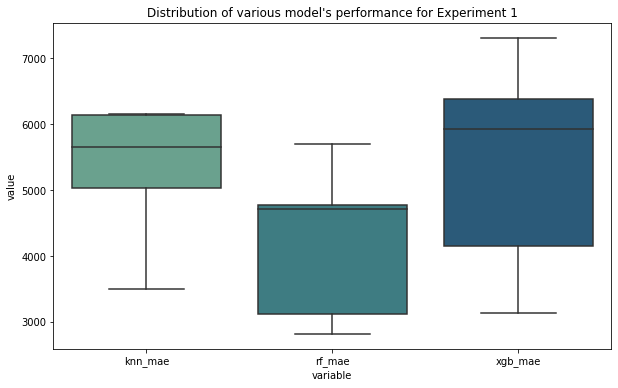

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(x="variable", y="value", data=pd.melt(exp1_results_df), palette='crest')
plt.title("Distribution of various model's performance for Experiment 1")
plt.show()

#### Deepdive hyperparameter tuning of the Random Forest Regressor as the performance of RF as better than the remaning two regressors

In [ ]:
from sklearn.model_selection import ShuffleSplit

exp1_sl_grid = GridSearchCV(RandomForestRegressor(),
                    param_grid  = {'max_depth': list(np.arange(20,80)),'max_features' : ['auto','sqrt', 'log2'], 'n_estimators': list(np.arange(1,30))},
                    cv = KFold(n_splits=5, shuffle=True, random_state=1),
                    scoring='neg_mean_absolute_error')

exp1_sl_grid.fit(trainx_exp1,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                                       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, ...],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29]},
             scoring='neg_mean_absolute_error')

In [ ]:
print("Best Score: ", exp1_sl_grid.best_score_)
print("Best Parameters: ",exp1_sl_grid.best_params_)

Best Score:  -3878.9381359639397
Best Parameters:  {'max_depth': 23, 'max_features': 'auto', 'n_estimators': 3}


#### Creating a distribution of MAE on the Test Datasets in oreder to create a 95% Confidence interval of the predictions on the Test Dataset

In [ ]:
from sklearn.metrics import mean_absolute_error
exp1_test_mae=[]
exp1_model= RandomForestRegressor(max_depth= 23, max_features= 'auto', n_estimators= 3)
exp1_mod_list=[]
for i in range(20):
    exp1_model.fit(trainx_exp1,train_y)
    exp1_mod_list.append(exp1_model)
    exp1_pred= exp1_model.predict(testx_exp1)
    exp1_test_mae.append(mean_absolute_error(test_y,exp1_pred))

#### **Results** Performance of best selected model from experiment 1 on Test dataset.

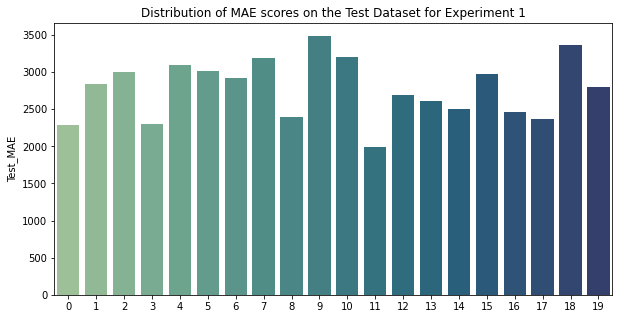

In [ ]:
exp1_test_mae= pd.DataFrame(exp1_test_mae)
exp1_test_mae.columns= ['Test_MAE']

plt.figure(figsize=(10,5))
sns.barplot(x= exp1_test_mae.index,y='Test_MAE',data= exp1_test_mae, palette='crest')
plt.title('Distribution of MAE scores on the Test Dataset for Experiment 1')
plt.show()

### 95% Confidence Interval of Test Predictions for Experiment 1

In [ ]:
print("Mean Test MAE for Experiment 1: ",exp1_test_mae['Test_MAE'].mean())
print("Std Dev of MAE for Experiment 2: ",exp1_test_mae['Test_MAE'].std())

ci= 2.0935*exp1_test_mae['Test_MAE'].std()

lower_interval= exp1_test_mae['Test_MAE'].mean()-ci
upper_interval= exp1_test_mae['Test_MAE'].mean()+ci

print("The 95% interval of Test MAE for Experiment 1 ranges between {} and {}".format(lower_interval,upper_interval))

Mean Test MAE for Experiment 1:  2775.2470367422625
Std Dev of MAE for Experiment 2:  402.35543760075996
The 95% interval of Test MAE for Experiment 1 ranges between 1932.9159281250713 and 3617.5781453594536


### Experiment 1(a): Feature Importance attribute of the Random Forests Regressor was used to extract features with importance greater than 0.01.

<Figure size 720x288 with 0 Axes>

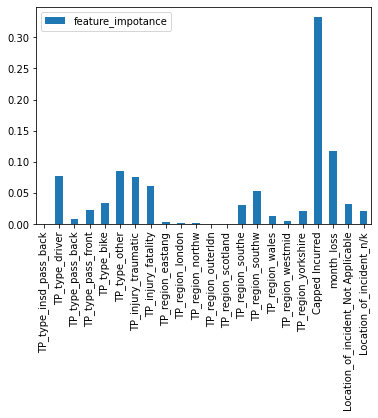

In [ ]:
exp1_impdf= pd.DataFrame(exp1_bestmodel.feature_importances_,index=trainx_exp1.columns)
exp1_impdf.columns=['feature_impotance']
exp1_impdf

plt.figure(figsize=(10,4))
exp1_impdf.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()
plt.show()

In [ ]:
exp1_newfeatures= list(exp1_impdf[exp1_impdf['feature_impotance']>0.01].index)
exp1_newfeatures

['TP_type_driver',
 'TP_type_pass_front',
 'TP_type_bike',
 'TP_type_other',
 'TP_injury_traumatic',
 'TP_injury_fatality',
 'TP_region_southe',
 'TP_region_southw',
 'TP_region_wales',
 'TP_region_yorkshire',
 'Capped Incurred',
 'month_loss',
 'Location_of_incident_Not Applicable',
 'Location_of_incident_n/k']

### Model evaluation and hyperparameter tuning has been carried out further on the selected features as part of experiment 1(a)

In [ ]:
trainx_exp1_rev= trainx_exp1[exp1_newfeatures]
testx_exp1_rev= testx_exp1[exp1_newfeatures]

In [ ]:
from sklearn.model_selection import ShuffleSplit

exp1_rev_grid = GridSearchCV(RandomForestRegressor(),
                    param_grid  = {'max_depth': list(np.arange(1,50)),'max_features' : ['auto','sqrt', 'log2'], 'n_estimators': list(np.arange(1,30))},
                    cv = KFold(n_splits=5, shuffle=True, random_state=1),
                    scoring='neg_mean_absolute_error')

exp1_rev_grid.fit(trainx_exp1_rev,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29]},
             scoring='neg_mean_absolute_error')

In [ ]:
print("Best Score: ", exp1_rev_grid.best_score_)
print("Best Parameters: ",exp1_rev_grid.best_params_)

Best Score:  -4044.515046129781
Best Parameters:  {'max_depth': 38, 'max_features': 'auto', 'n_estimators': 5}


#### Deepdive hyperparameter tuning of the Random Forest Regressor as the performance of RF as better than the remaning two regressors

In [ ]:
from sklearn.metrics import mean_absolute_error
exp1rev_test_mae=[]
exp1rev_model= RandomForestRegressor(max_depth= 38, max_features= 'auto', n_estimators= 5)
exp1rev_mod_list=[]
for i in range(20):
    exp1rev_model.fit(trainx_exp1_rev,train_y)
    exp1rev_mod_list.append(exp1rev_model)
    exp1rev_pred= exp1rev_model.predict(testx_exp1_rev)
    exp1rev_test_mae.append(mean_absolute_error(test_y,exp1rev_pred))

#### **Results** Performance of best selected model from experiment 1(a) on Test dataset.

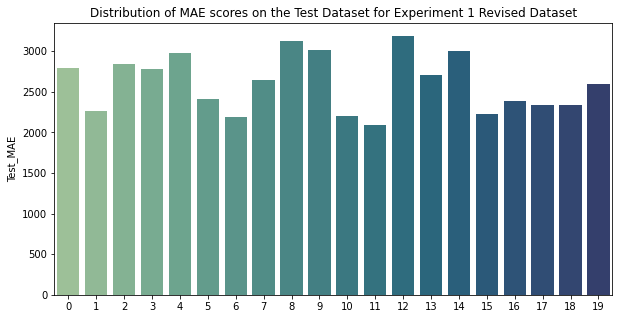

In [ ]:
exp1rev_test_mae= pd.DataFrame(exp1rev_test_mae)
exp1rev_test_mae.columns= ['Test_MAE']

plt.figure(figsize=(10,5))
sns.barplot(x= exp1rev_test_mae.index,y='Test_MAE',data= exp1rev_test_mae, palette='crest')
plt.title('Distribution of MAE scores on the Test Dataset for Experiment 1 Revised Dataset')
plt.show()

### 95% Confidence Interval of Test Predictions for Experiment 1(a)

In [ ]:
print("Mean Test MAE for Experiment 1 revised dataset: ",exp1rev_test_mae['Test_MAE'].mean())
print("Std Dev of MAE for Experiment 1 revised dataset: ",exp1rev_test_mae['Test_MAE'].std())

ci= 2.0935*exp1rev_test_mae['Test_MAE'].std()

lower_interval= exp1rev_test_mae['Test_MAE'].mean()-ci
upper_interval= exp1rev_test_mae['Test_MAE'].mean()+ci

print("The 95% interval of Test MAE for Experiment 1 revised dataset ranges between {} and {}".format(lower_interval,upper_interval))

Mean Test MAE for Experiment 1 revised dataset:  2606.029304848952
Std Dev of MAE for Experiment 1 revised dataset:  347.80954005095987
The 95% interval of Test MAE for Experiment 1 revised dataset ranges between 1877.8900327522674 and 3334.1685769456367


# **Exepriment 2**: Using the Features Extracted from Lasso Co-efficients 

In [ ]:
trainx_exp2= train_x_scl[lasso_features]
testx_exp2= test_x_scl[lasso_features]

In [ ]:
with open('/content/drive/MyDrive/Hastings/trainx_exp2.pkl','wb') as tr_exp2:
    pickle.dump(trainx_exp2,tr_exp2)
with open('/content/drive/MyDrive/Hastings/testx_exp2.pkl','wb') as te_exp2:
    pickle.dump(testx_exp2,te_exp2)

In [ ]:
with open('/content/drive/MyDrive/Hastings/trainx_exp2.pkl','rb') as tr_exp2:
    trainx_exp2= pickle.load(tr_exp2)
with open('/content/drive/MyDrive/Hastings/testx_exp2.pkl','rb') as te_exp2:
    testx_exp2= pickle.load(te_exp2)

In [ ]:
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Initializing Classifiers
reg1 = KNeighborsRegressor()
reg2 = RandomForestRegressor()
reg3 = xgb.XGBRegressor()

# Setting up the parameter grids
param_grid1 = [{'algorithm': ['ball_tree'],'leaf_size': [50], 'n_neighbors': [1,13,25,35,55,75,91,101],'p': [1, 2]}]

param_grid2 = [{'n_estimators': [1,10,100,300,700,1000,5000],
                'max_depth': list(np.arange(5, 50))}]

param_grid3 = [{'n_estimators': [1,10,100,300,700,1000,5000],
                'max_depth': list(np.arange(1, 10))}]

In [ ]:
gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                            (reg1, reg2, reg3),
                            ('KNN','RF','XGB')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [ ]:
MAE_dict=[]
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, valid_idx in outer_cv.split(trainx_exp2, train_y):
        
        gridcvs[name].fit(trainx_exp2.iloc[train_idx,:], train_y.iloc[train_idx]) 
        print('\n        Best MAE (avg. of inner test folds)', (gridcvs[name].best_score_))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        in_best_reg= gridcvs[name].best_estimator_
        in_pred= in_best_reg.predict(trainx_exp2.iloc[valid_idx,:])
        
        outer_scores.append((-1*mean_absolute_error(train_y[valid_idx],in_pred)))
    
    m_dict= {name:outer_scores}
    MAE_dict.append(m_dict)
    print('\n    Outer Loop:')
    print('MAE Values for all the outer loops: ',outer_scores)
    print('Mean MAE of all MAE in outer loops: ',np.mean(outer_scores))

-------------------------------------------------- 

Algorithm: KNN
    Inner loop:

        Best MAE (avg. of inner test folds) -8121.74187539755
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -7880.827560117546
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -7934.438628898952
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -8934.004351487809
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

        Best MAE (avg. of inner test folds) -8502.91389351884
        Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 13, 'p': 1}

    Outer Loop:
MAE Values for all the outer loops:  [-8163.717150529353, -9357.00611440831, -9328.143759175455, -531

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -4065.7214090120146
        Best parameters: {'max_depth': 29, 'n_estimators': 10}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -3318.4451352883852
        Best parameters: {'max_depth': 24, 'n_estimators': 10}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -3826.2642458322575
        Best parameters: {'max_depth': 18, 'n_estimators': 1}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -4420.694787163659
        Best parameters: {'max_depth': 7, 'n_estimators': 10}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best MAE (avg. of inner test folds) -4192.020854458025
        Best parameters: {'max_depth': 13, 'n_estimators': 1}

    Outer Loop:
MAE Values for all the outer loops:  [-5479.332055370273, -5370.427222492162, -7920.53292729058, -3035.5491674381133, -3832.688348832517]
Mean MAE of all MAE in outer loops:  -5127.705944284729
-------------------------------------------------- 

Algorithm: XGB
    Inner loop:


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[14:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -4414.718176778195
        Best parameters: {'max_depth': 9, 'n_estimators': 100}
[14:09:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -3955.5231728764957
        Best parameters: {'max_depth': 5, 'n_estimators': 100}
[14:13:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -5200.867912142808
        Best parameters: {'max_depth': 3, 'n_estimators': 100}
[14:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

        Best MAE (avg. of inner test folds) -5230.962384176306
        Best parameters: {'max_depth': 9, 'n_e

In [12]:
exp2_dict= {'knn_mae':[8163.717150529353, 9357.00611440831, 9328.143759175455, 5313.741781247754, 7078.940018668373],
            'rf_mae': [5479.332055370273, 5370.427222492162, 7920.53292729058, 3035.5491674381133, 3832.688348832517],
            'xgb_mae':[5459.755467571405, 7064.6343450642635, 6863.286690291598, 3772.7649098736615, 3905.659712230313]}

exp2_results_df= pd.DataFrame(exp2_dict)
exp2_results_df

,knn_mae,rf_mae,xgb_mae
0,8163.717151,5479.332055,5459.755468
1,9357.006114,5370.427222,7064.634345
2,9328.143759,7920.532927,6863.286690
3,5313.741781,3035.549167,3772.764910
4,7078.940019,3832.688349,3905.659712


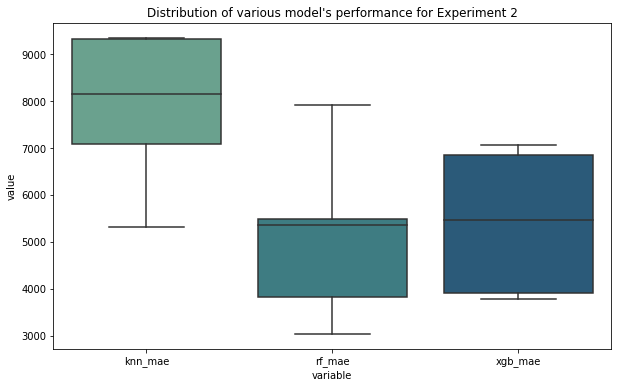

In [13]:
plt.figure(figsize=(10,6))
sns.boxplot(x="variable", y="value", data=pd.melt(exp2_results_df), palette='crest')
plt.title("Distribution of various model's performance for Experiment 2")
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

exp2_sl_grid = GridSearchCV(RandomForestRegressor(),
                    param_grid  = {'max_depth': list(np.arange(1,50)),'max_features' : ['auto','sqrt', 'log2'], 'n_estimators': list(np.arange(1,30))},
                    cv = KFold(n_splits=5, shuffle=True, random_state=1),
                    scoring='neg_mean_absolute_error')

exp2_sl_grid.fit(trainx_exp2,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29]},
             scoring='neg_mean_absolute_error')

In [ ]:
print("Best Score: ", exp2_sl_grid.best_score_)
print("Best Parameters: ",exp2_sl_grid.best_params_)

Best Score:  -3983.1857638563915
Best Parameters:  {'max_depth': 13, 'max_features': 'auto', 'n_estimators': 9}


In [ ]:
exp2_bestmodel= RandomForestRegressor(max_depth= 13, max_features= 'auto', n_estimators= 9)
exp2_bestmodel.fit(trainx_exp2,train_y)

In [ ]:
with open('/content/drive/MyDrive/Hastings/exp2_bestmodel.pkl','wb') as exp2_bm:
    pickle.dump(exp2_bestmodel,exp2_bm)

#### Deepdive hyperparameter tuning of the Random Forest Regressor as the performance of RF as better than the remaning two regressors

In [ ]:
from sklearn.metrics import mean_absolute_error
exp2_test_mae=[]
exp2_model= RandomForestRegressor(max_depth= 13, max_features= 'auto', n_estimators= 9)
exp2_mod_list=[]
for i in range(20):
    exp2_model.fit(trainx_exp2,train_y)
    exp2_mod_list.append(exp2_model)
    exp2_pred= exp2_model.predict(testx_exp2)
    exp2_test_mae.append(mean_absolute_error(test_y,exp2_pred))

#### **Results** Performance of best selected model from experiment 2 on Test dataset.

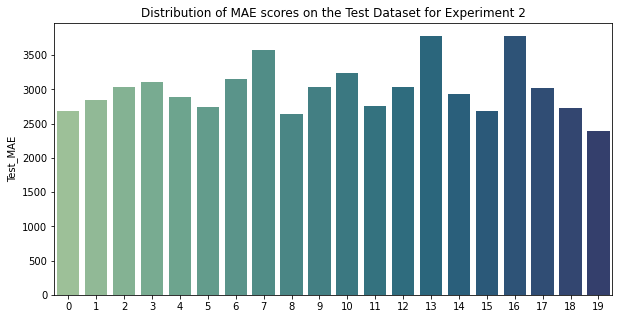

In [ ]:
exp2_test_mae= pd.DataFrame(exp2_test_mae)
exp2_test_mae.columns= ['Test_MAE']

plt.figure(figsize=(10,5))
sns.barplot(x= exp2_test_mae.index,y='Test_MAE',data= exp2_test_mae, palette='crest')
plt.title('Distribution of MAE scores on the Test Dataset for Experiment 2')
plt.show()

### 95% Confidence Interval of Test Predictions for Experiment 2

In [ ]:
print("Mean Test MAE for Experiment 1: ",exp2_test_mae['Test_MAE'].mean())
print("Std Dev of MAE for Experiment 2: ",exp2_test_mae['Test_MAE'].std())

ci= 2.0935*exp2_test_mae['Test_MAE'].std()

lower_interval= exp2_test_mae['Test_MAE'].mean()-ci
upper_interval= exp2_test_mae['Test_MAE'].mean()+ci

print("The 95% interval of Test MAE for Experiment 1 ranges between {} and {}".format(lower_interval,upper_interval))

Mean Test MAE for Experiment 1:  3004.552883562351
Std Dev of MAE for Experiment 2:  369.23306832266877
The 95% interval of Test MAE for Experiment 1 ranges between 2231.5634550288437 and 3777.542312095858


### Model evaluation and hyperparameter tuning has been carried out further on the selected features as part of experiment 2(a)

<Figure size 720x288 with 0 Axes>

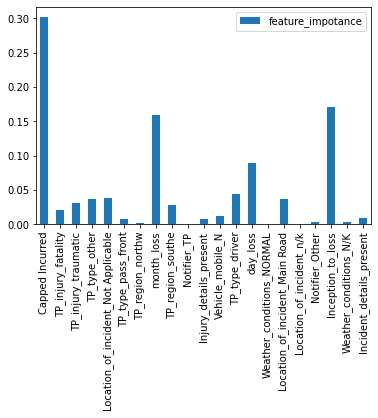

In [ ]:
exp2_impdf= pd.DataFrame(exp2_bestmodel.feature_importances_,index=trainx_exp2.columns)
exp2_impdf.columns=['feature_impotance']
exp2_impdf

plt.figure(figsize=(10,4))
exp2_impdf.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()
plt.show()

In [ ]:
exp2_newfeatures= list(exp2_impdf[exp2_impdf['feature_impotance']>0.01].index)
exp2_newfeatures

['Capped Incurred',
 'TP_injury_fatality',
 'TP_injury_traumatic',
 'TP_type_other',
 'Location_of_incident_Not Applicable',
 'month_loss',
 'TP_region_southe',
 'Vehicle_mobile_N',
 'TP_type_driver',
 'day_loss',
 'Location_of_incident_Main Road',
 'Inception_to_loss']

In [ ]:
trainx_exp2_rev= trainx_exp2[exp2_newfeatures]
testx_exp2_rev= testx_exp2[exp2_newfeatures]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

exp2_rev_grid = GridSearchCV(RandomForestRegressor(),
                    param_grid  = {'max_depth': list(np.arange(1,50)),'max_features' : ['auto','sqrt', 'log2'], 'n_estimators': list(np.arange(1,30))},
                    cv = KFold(n_splits=5, shuffle=True, random_state=1),
                    scoring='neg_mean_absolute_error')

exp2_rev_grid.fit(trainx_exp2_rev,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29]},
             scoring='neg_mean_absolute_error')

In [ ]:
print("Best Score: ", exp2_rev_grid.best_score_)
print("Best Parameters: ",exp2_rev_grid.best_params_)

Best Score:  -3895.555055992034
Best Parameters:  {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 18}


In [ ]:
from sklearn.metrics import mean_absolute_error
exp2rev_test_mae=[]
exp2rev_model= RandomForestRegressor(max_depth=7, max_features= 'auto', n_estimators= 18)
exp2rev_mod_list=[]
for i in range(20):
    exp2rev_model.fit(trainx_exp2_rev,train_y)
    exp2rev_mod_list.append(exp2rev_model)
    exp2rev_pred= exp2rev_model.predict(testx_exp2_rev)
    exp2rev_test_mae.append(mean_absolute_error(test_y,exp2rev_pred))

#### **Results** Performance of best selected model from experiment 2(a) on Test dataset.

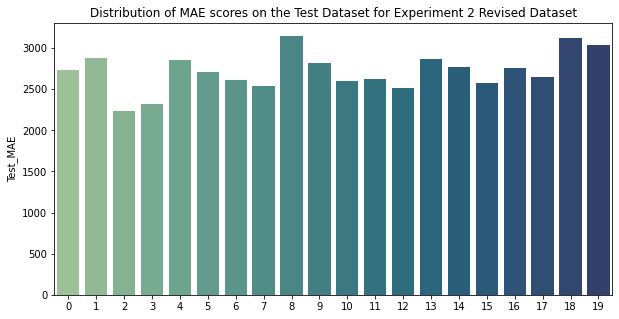

In [ ]:
exp2rev_test_mae= pd.DataFrame(exp2rev_test_mae)
exp2rev_test_mae.columns= ['Test_MAE']

plt.figure(figsize=(10,5))
sns.barplot(x= exp2rev_test_mae.index,y='Test_MAE',data= exp2rev_test_mae, palette='crest')
plt.title('Distribution of MAE scores on the Test Dataset for Experiment 2 Revised Dataset')
plt.show()

### 95% Confidence Interval of Test Predictions for Experiment 2(a)

In [ ]:
print("Mean Test MAE for Experiment 2 Revised Dataset: ",exp2rev_test_mae['Test_MAE'].mean())
print("Std Dev of MAE for Experiment 2 Revised Dataset: ",exp2rev_test_mae['Test_MAE'].std())

ci= 2.0935*exp2rev_test_mae['Test_MAE'].std()

lower_interval= exp2rev_test_mae['Test_MAE'].mean()-ci
upper_interval= exp2rev_test_mae['Test_MAE'].mean()+ci

print("The 95% interval of Test MAE for Experiment 2 revised dataset ranges between {} and {}".format(lower_interval,upper_interval))

Mean Test MAE for Experiment 2 Revised Dataset:  2719.563007783051
Std Dev of MAE for Experiment 2 Revised Dataset:  237.02084455606706
The 95% interval of Test MAE for Experiment 2 revised dataset ranges between 2223.3598697049247 and 3215.7661458611774


## **Results Summary**

In [15]:
from prettytable import PrettyTable
p=PrettyTable()

p.field_names=["Experiment","Description", "Model","Test_MAE_95%CI_Lowerbound","Test_MAE_95%CI_Upperbound"]

p.add_row(["Exp-1","Featrues Selected from RFE feature selction technique","Random_Forest", 1932.91,3617.57])
p.add_row(["Exp-1(a)","Further Feature selection from Exp1","Random_Forest",1877.89, 3334.16])
p.add_row(["Exp-2","Feature Selected from Lasso feature selction technique","Random_Forest",2231.56, 3777.54])
p.add_row(["Exp-2(a)","Further Feature selection from Exp2","Random_Forest",2223.35, 3215.76])

print(p)

+------------+--------------------------------------------------------+---------------+---------------------------+---------------------------+
| Experiment |                      Description                       |     Model     | Test_MAE_95%CI_Lowerbound | Test_MAE_95%CI_Upperbound |
+------------+--------------------------------------------------------+---------------+---------------------------+---------------------------+
|   Exp-1    | Featrues Selected from RFE feature selction technique  | Random_Forest |          1932.91          |          3617.57          |
|  Exp-1(a)  |          Further Feature selection from Exp1           | Random_Forest |          1877.89          |          3334.16          |
|   Exp-2    | Feature Selected from Lasso feature selction technique | Random_Forest |          2231.56          |          3777.54          |
|  Exp-2(a)  |          Further Feature selection from Exp2           | Random_Forest |          2223.35          |          3215.76    